In [23]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread', 'imsave', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load and check images

In [163]:
#filename = '/Users/jug/Dropbox/WorkingData/CSBD/Collaborations/CBG_Tabler/MAX_28_osx_2_1002.tif'
filename = '/Users/jug/Dropbox/WorkingData/CSBD/Collaborations/CBG_Tabler/MAX_28_osx_2_1002-scaled.25.tif'

# filename = '/Users/jug/Dropbox/WorkingData/CSBD/Collaborations/CBG_Tabler/MAX_C1-E13.5_osx_WT_1004.tif'
# filename = '/Users/jug/Dropbox/WorkingData/CSBD/Collaborations/CBG_Tabler/20170608/MAX_WT_1001.tif'

stack = imread(filename)
print 'Stack shape:',stack.shape

Stack shape: (22, 704, 819)


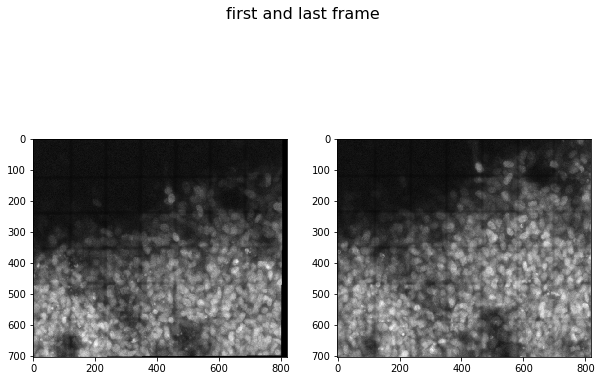

In [164]:
pylab.rcParams['figure.figsize'] = (10, 7)
fig = plt.figure()
fig.suptitle('first and last frame', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(stack[0], plt.get_cmap('gray'))
ax = fig.add_subplot(122)
ax.imshow(stack[-1], plt.get_cmap('gray'))

# Define functions

In [165]:
#del globals()['compute_flow']
def compute_flow( flowchannel, start=0, end=-1 ):
        num_frames = flowchannel.shape[0]

        assert len(flowchannel.shape) == 3
        assert start >= 0
        assert start < num_frames
        assert end < num_frames

        if ( end==-1 ):
            end = num_frames
        print '# of frames to use: %d (%d->%d)'%((end-start),start+1,end)
        
        flows = [None] * (end-start-1)
        prvs = flowchannel[start]
        for i,f in enumerate(range(start+1,end)):
            nxt = flowchannel[f]
            flow = cv2.calcOpticalFlowFarneback(prev=prvs,
                                                next=nxt,
                                                pyr_scale=0.5,
                                                levels=3,
                                                winsize=25,
                                                iterations=10,
                                                poly_n=7,
                                                poly_sigma=1.5,
                                                flags=0)
            flows[i] = flow
            prvs = nxt
            print '%d>%d -'%(f,f+1),
        print '-- done!'
        return flows

# Compute flow

In [173]:
flows = compute_flow(stack)

# of frames to use: 22 (1->22)
1>2 - 2>3 - 3>4 - 4>5 - 5>6 - 6>7 - 7>8 - 8>9 - 9>10 - 10>11 - 11>12 - 12>13 - 13>14 - 14>15 - 15>16 - 16>17 - 17>18 - 18>19 - 19>20 - 20>21 - 21>22 - -- done!


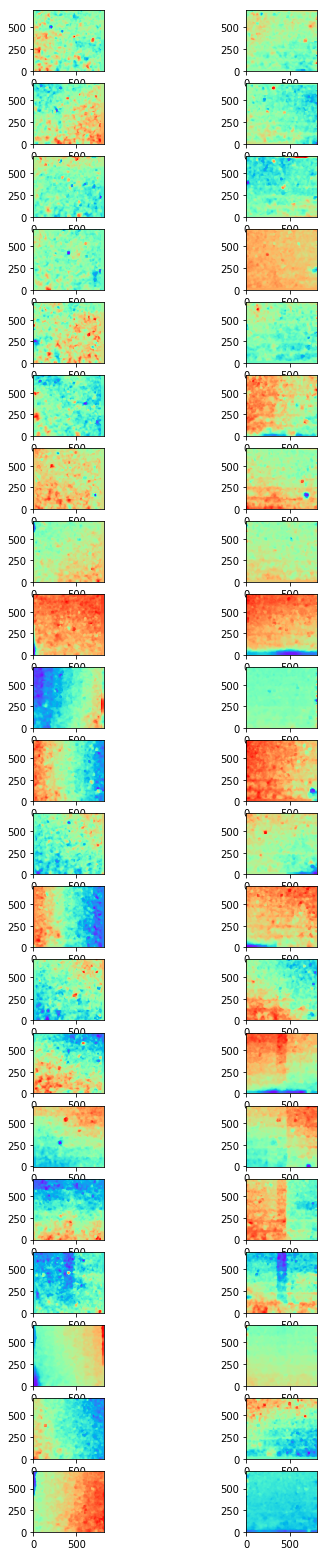

In [174]:
pylab.rcParams['figure.figsize'] = (7, 28)
fig = plt.figure()
for i in range(len(flows)):
    ax = fig.add_subplot(len(flows),2,1+2*i)
    ax.imshow( np.einsum('xyc->cxy', flows[i])[0], plt.get_cmap('rainbow'), origin='lower')
    ax = fig.add_subplot(len(flows),2,2+2*i)
    ax.imshow( np.einsum('xyc->cxy', flows[i])[1], plt.get_cmap('rainbow'), origin='lower') #, plt.get_cmap('gray')

# Compute average flow and plot it

In [175]:
def compute_averages(flow):
    flowx = np.einsum('xyc->cxy', flow)[0]
    flowy = np.einsum('xyc->cxy', flow)[1]
    valsx = []
    valsy = []
    rowlen = flowx.shape[1]
    for row in range(flowx.shape[0]):
        vec = [0,0]
        vec[0] = np.sum(flowx[row])
        vec[1] = np.sum(flowy[row])
        valsx.extend( [vec[0]/rowlen] )
        valsy.extend( [vec[1]/rowlen] )
    return valsx, valsy
        
vxs = []
vys = []
for flow in flows:
    vx, vy = compute_averages(flow)
    vxs.extend( [vx] )
    vys.extend( [vy] )

In [180]:
def plot_frame_averages(t, img1, img2, valsx, valsy, flow):
    maxV = 20
    fig = plt.figure()
    fig.suptitle('t=%d'%(t+1), fontsize=16)
    
    ax = fig.add_subplot(141)
    ax.set_title('row flows in x and y direction')
    ax.set_xlabel('row# (bottom to top)')
    ax.set_ylabel('avg pixel movement (upwards)')
    ax.plot(valsx,'--',color='gray',lw=1)
    ax.plot(valsy,'b-',lw=2)
    ax.set_ylim( [-maxV,maxV] )
    
    ax = fig.add_subplot(142)
    ax.imshow(img1, plt.get_cmap('gray'), origin='lower')

    ax = fig.add_subplot(143)
    ax.imshow(img2, plt.get_cmap('gray'), origin='lower')
    
    ax = fig.add_subplot(144)
    im = ax.imshow( np.einsum('xyc->cxy', flow)[1], plt.get_cmap('rainbow'), vmin=-maxV, vmax=maxV, origin='lower')
    ax.axis('off')
    fig.colorbar(im)

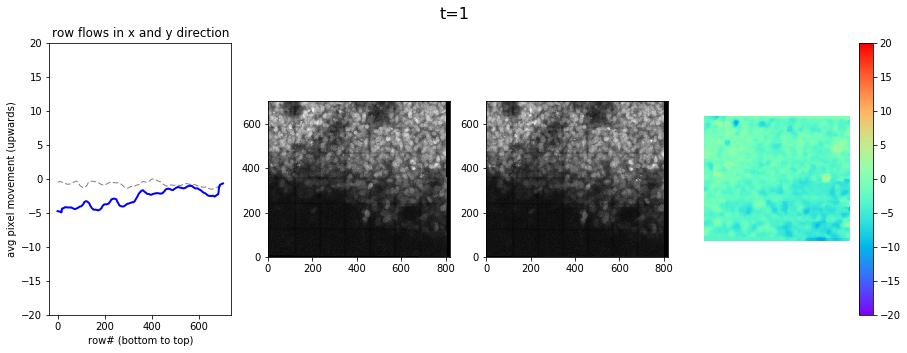

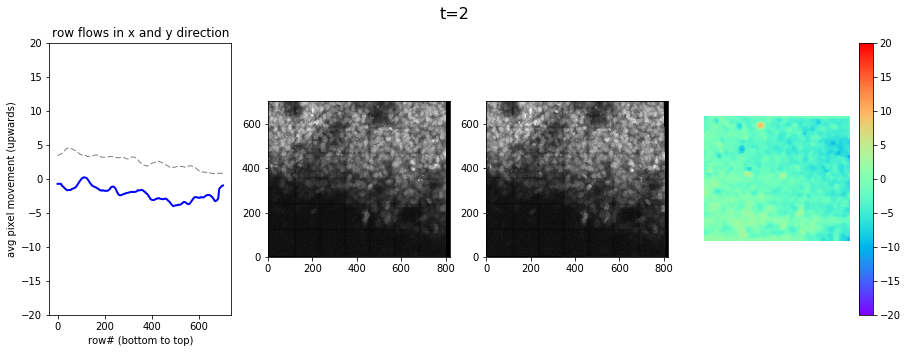

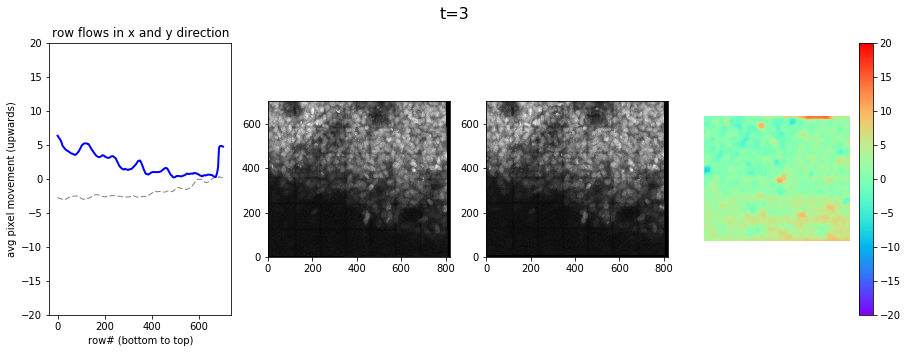

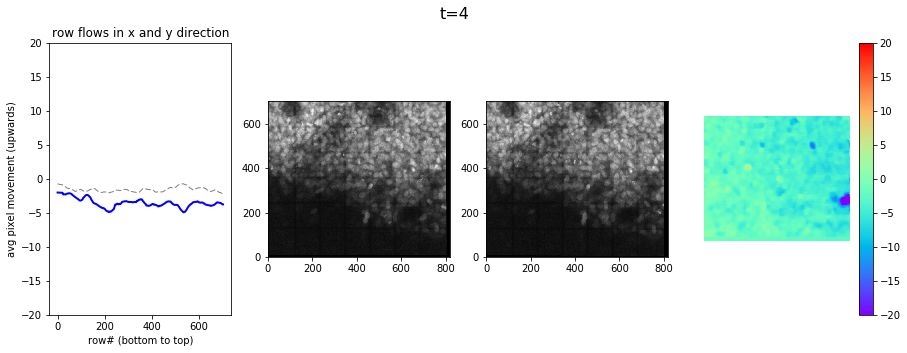

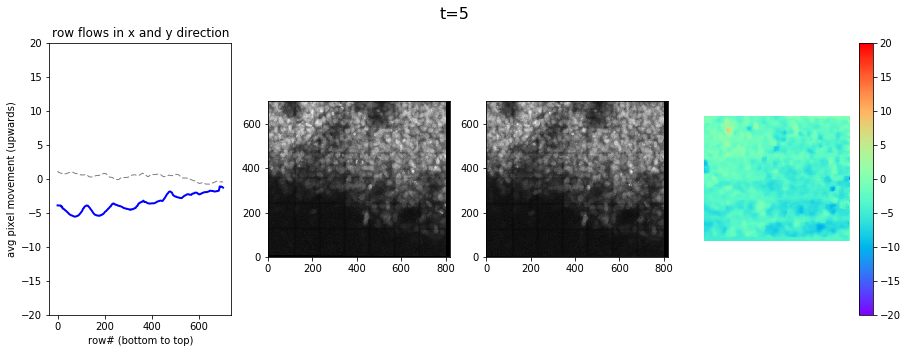

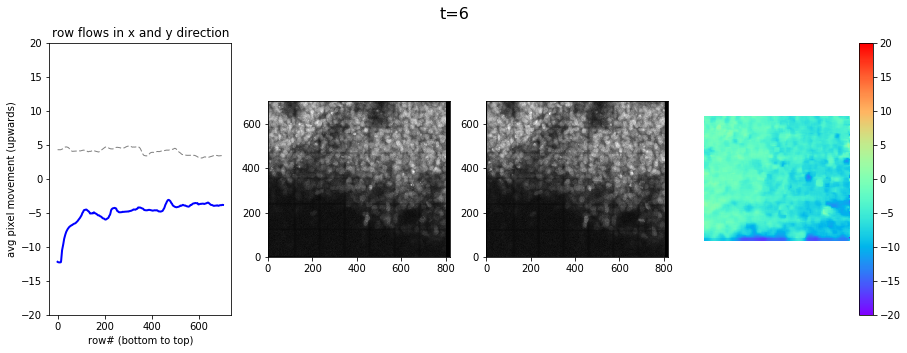

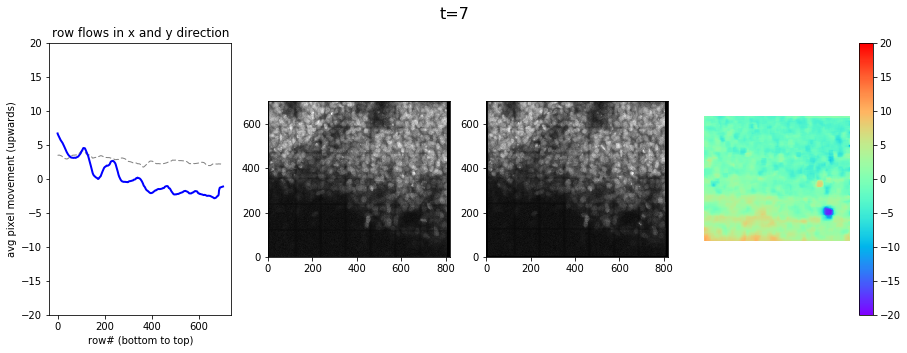

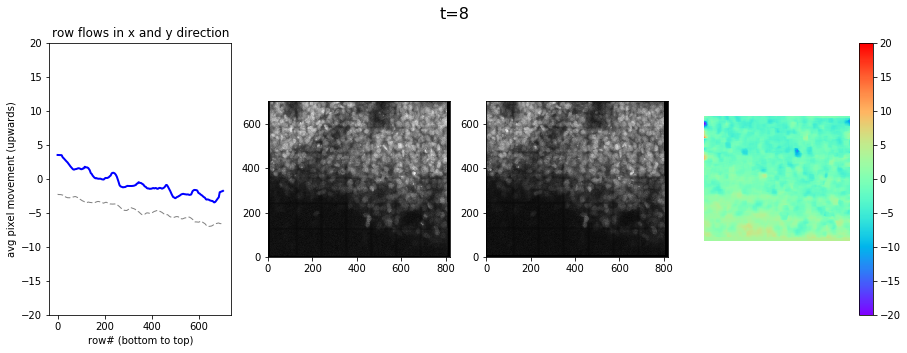

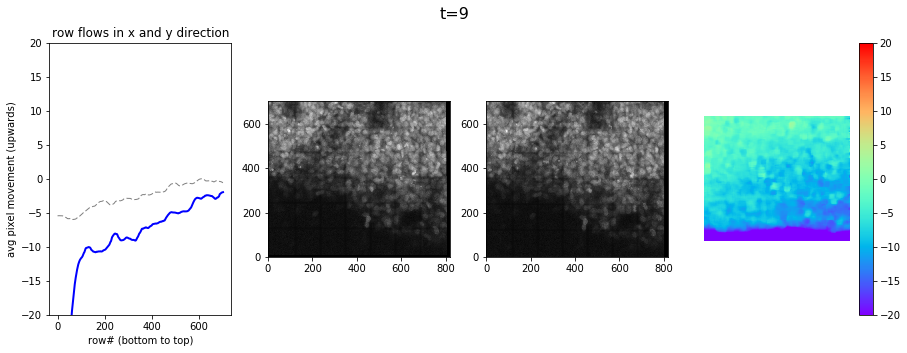

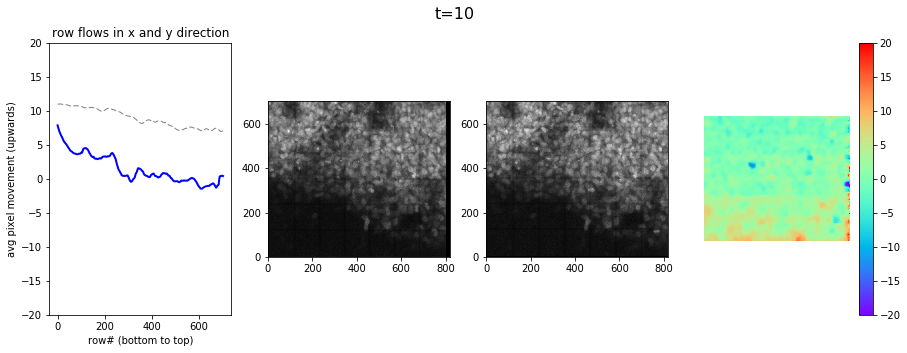

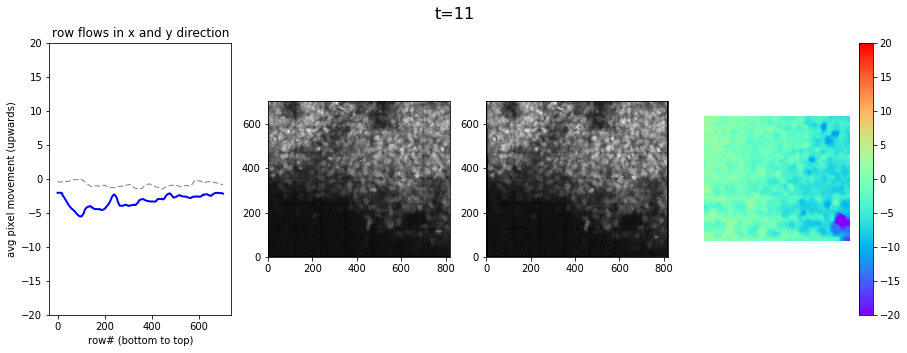

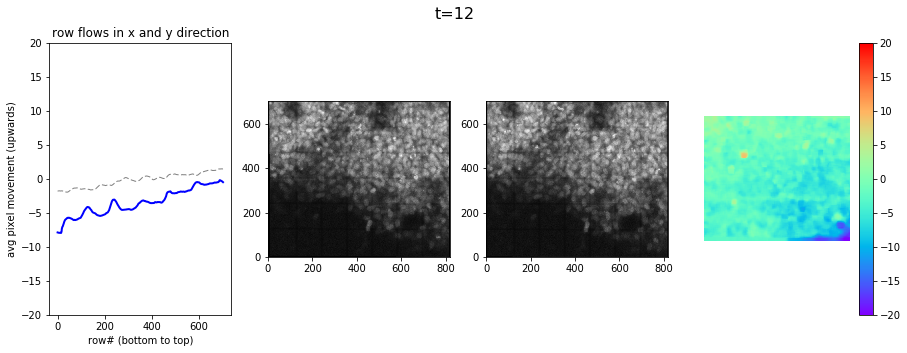

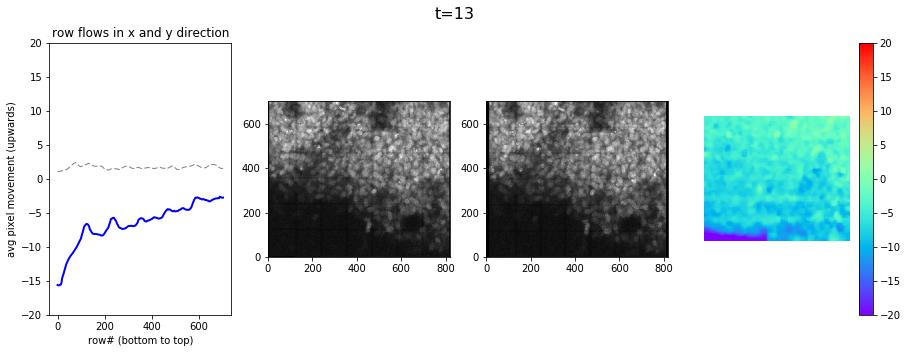

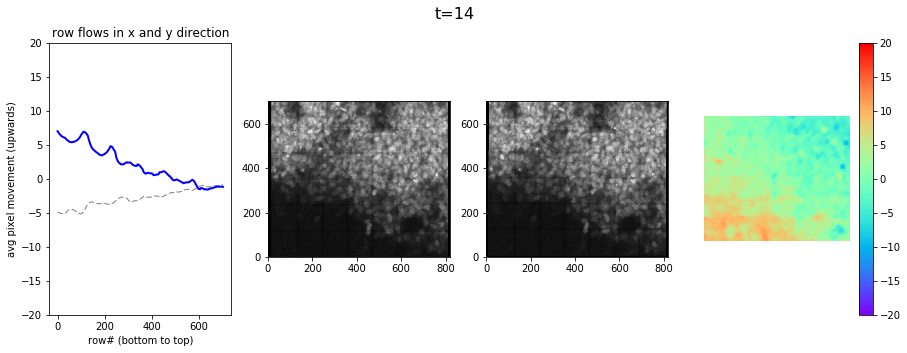

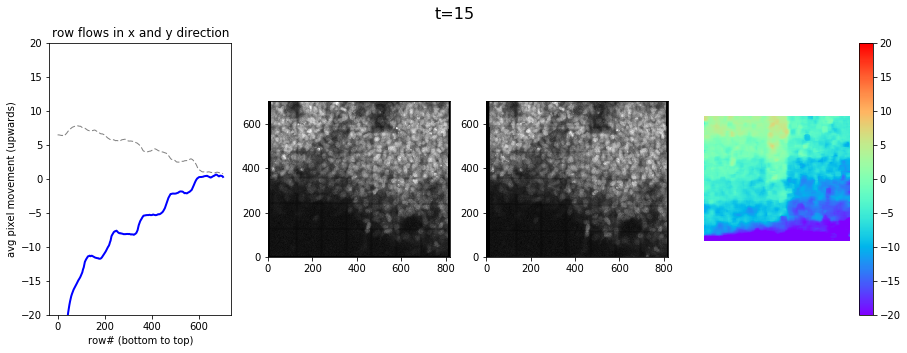

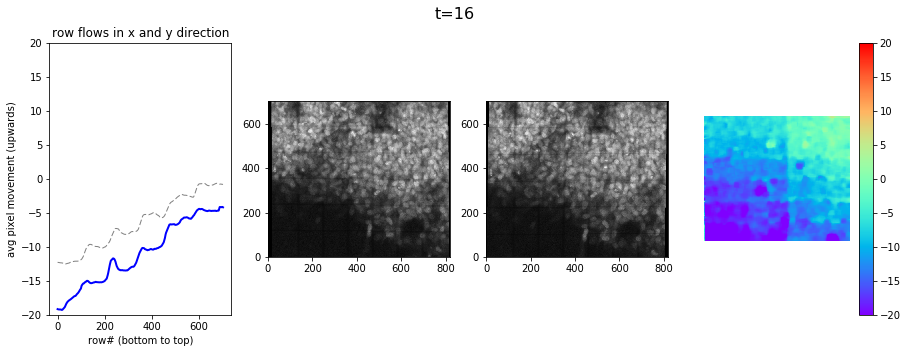

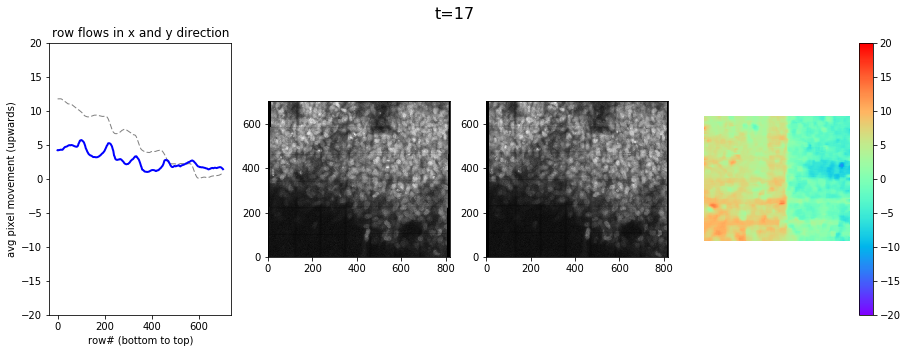

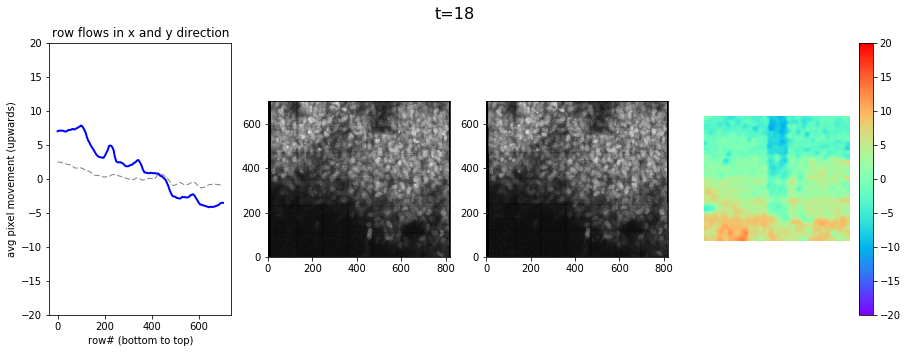

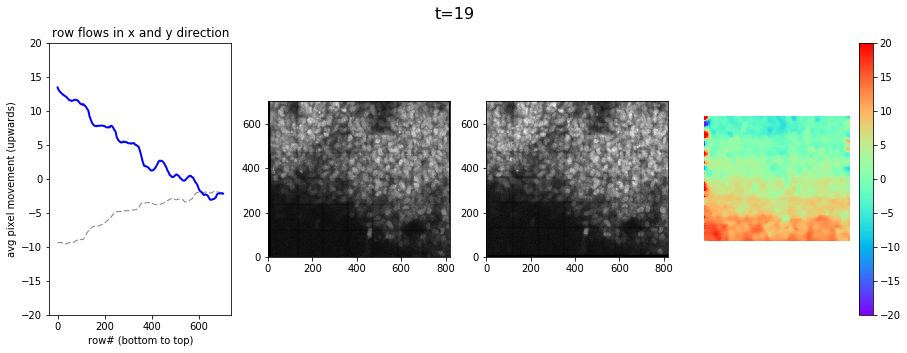

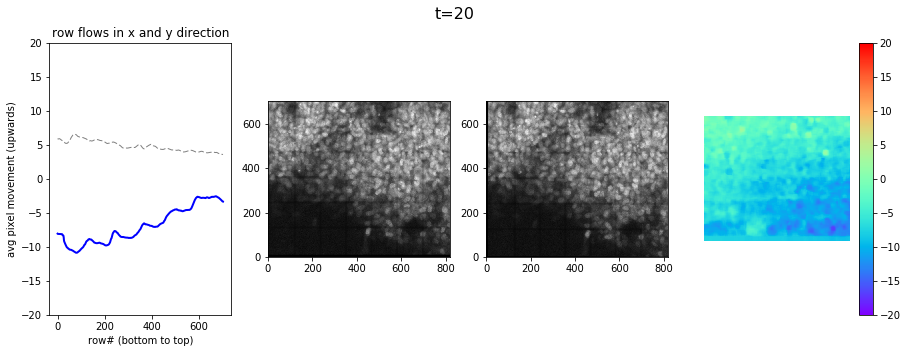

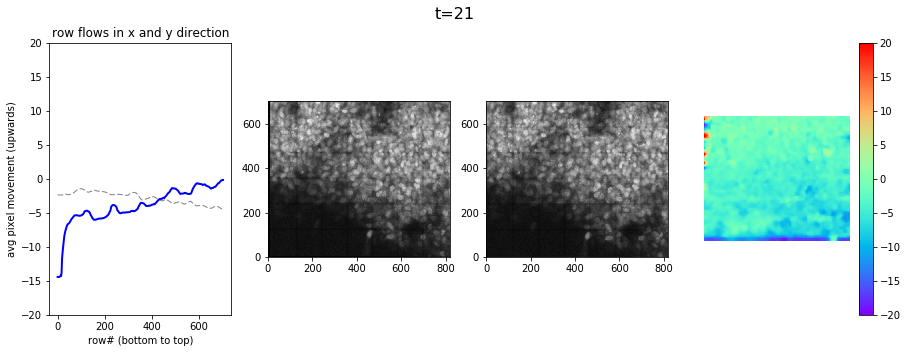

In [181]:
pylab.rcParams['figure.figsize'] = (15, 5)
for t in range(len(flows)):
    plot_frame_averages(t, stack[t], stack[t+1], vxs[t], vys[t], flows[t])